# Introducción al Aprendizaje Automatizado: Trabajo Práctico N° 3
## Natalia Mellino

In [118]:
# imports

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
from sklearn.tree import DecisionTreeClassifier

from ej4tp1 import ej4tp1, generate_dataframe_a, generate_dataframe_b

warnings.filterwarnings("ignore")

In [60]:
# Función para entrenar y devolver el mejor clasificador

n_vecinos = [2, 4, 8, 16, 32]

def get_best_clf(x_train, y_train, x_test, y_test, x_val, y_val):
    errores_train = []
    errores_test = []
    errores_val = []
    best_e = None
    best_clf = None
    

    for n in n_vecinos:    
        clf = KNeighborsClassifier(n_neighbors=n)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        y_pred_train = clf.predict(x_train)
        y_pred_val = clf.predict(x_val)

        e_train = 1 - accuracy_score(y_train, y_pred_train)
        e_test = 1 - accuracy_score(y_test, y_pred)
        e_val = 1 - accuracy_score(y_val, y_pred_val)

        errores_test.append(e_test)
        errores_train.append(e_train)
        errores_val.append(e_val)

        if best_e is None or e_val < best_e:
            best_e = e_test
            best_clf = clf

    return errores_train, errores_val, errores_test, best_clf

In [74]:
def graficar_predicciones(x, y, cl, title=''):
    scatter = plt.scatter(x, y, c=cl)
    plt.legend(*scatter.legend_elements())
    plt.title(title)
    plt.show()

def graficar_errores(x, et, ev, ett, title=''):
    plt.plot(x, et, label='Train')
    plt.plot(x, ev, label='Validacion')
    plt.plot(x, ett, label='Test')
    plt.title(title)
    plt.legend()
    plt.show()

## Ejercicio 1

### Utilizando el método de k-vecinos

In [83]:
def ej1():
    cols_0 = ['x', 'y', 'Class']
    cols_2 = ['x', 'y', 'z', 'w', 'Class']
    train = pd.read_csv('espirales_con_ruido/c_0.data', names=cols_0)
    ntrain = pd.read_csv('espirales_con_ruido/c_2.data', names=cols_2)
    test = pd.read_csv('espirales_con_ruido/c_0.test', names=cols_0)
    ntest = pd.read_csv('espirales_con_ruido/c_2.test', names=cols_2)

    x_train, x_val, y_train, y_val = train_test_split(
        train.loc[ : , ['x', 'y'] ], 
        train.loc[ : , ['Class'] ], 
        test_size=0.2, 
        random_state=0
    )

    x_ntrain, x_nval, y_ntrain, y_nval = train_test_split(
        ntrain.loc[ : , ['x', 'y', 'z', 'w'] ], 
        ntrain.loc[ : , ['Class'] ], 
        test_size=0.2, 
        random_state=0
    )

    ### PARA DATOS SIN RUIDO

    et, ev, ett, clf = get_best_clf(x_train, y_train, test.loc[:, ['x', 'y']], test.loc[:, ['Class']], x_val, y_val)
    y_pred = clf.predict(test.loc[:, ['x', 'y']])

    # Errores
    graficar_errores(n_vecinos, et, ev, ett, 'Error sin ruido')
    # Predicciones
    graficar_predicciones(test.loc[:, ['x']], test.loc[:, ['y']], y_pred, 'Predicciones sin ruido')

    ### PARA DATOS CON RUIDO

    net, nev, nett, nclf = get_best_clf(x_ntrain, y_ntrain, ntest.loc[:, ['x', 'y', 'z', 'w']], ntest.loc[:, ['Class']], x_nval, y_nval)
    y_npred = nclf.predict(ntest.loc[:, ['x', 'y', 'z', 'w']])

    # Errores
    graficar_errores(n_vecinos, net, nev, nett, 'Error con ruido')
    # Predicciones
    graficar_predicciones(ntest.loc[:, ['x']], ntest.loc[:, ['y']], y_npred, 'Predicciones con ruido')
    

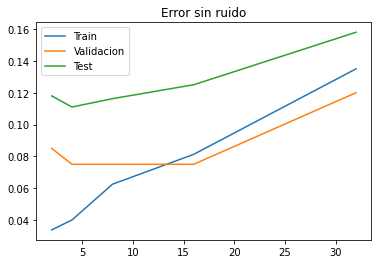

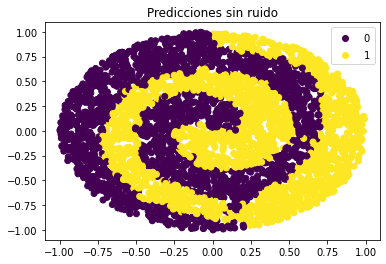

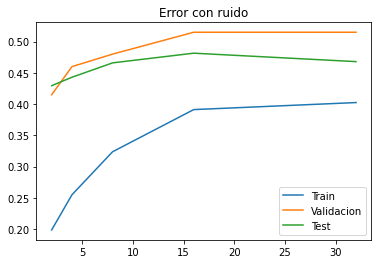

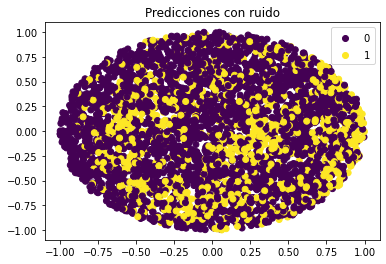

In [84]:
ej1()

### Utilizando Árboles de Desición

In [92]:
def ej1_ad():
    clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
    nclf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)

    cols_0 = ['x', 'y', 'Class']
    cols_2 = ['x', 'y', 'z', 'w', 'Class']
    train = pd.read_csv('espirales_con_ruido/c_0.data', names=cols_0)
    ntrain = pd.read_csv('espirales_con_ruido/c_2.data', names=cols_2)
    test = pd.read_csv('espirales_con_ruido/c_0.test', names=cols_0)
    ntest = pd.read_csv('espirales_con_ruido/c_2.test', names=cols_2)

    x_train, x_val, y_train, y_val = train_test_split(
        train.loc[ : , ['x', 'y'] ], 
        train.loc[ : , ['Class'] ], 
        test_size=0.2, 
        random_state=0
    )

    x_ntrain, x_nval, y_ntrain, y_nval = train_test_split(
        ntrain.loc[ : , ['x', 'y', 'z', 'w'] ], 
        ntrain.loc[ : , ['Class'] ], 
        test_size=0.2, 
        random_state=0
    )

    clf.fit(x_train, y_train)
    nclf.fit(x_ntrain, y_ntrain)

    ### Sin ruido

    y_pred_test = clf.predict(test.loc[ : , ['x', 'y'] ],)
    graficar_predicciones(test.loc[:, ['x']], test.loc[:, ['y']], y_pred_test, 'Predicciones sin ruido')

    ### Con ruido

    y_npred_test = nclf.predict(ntest.loc[ : , ['x', 'y', 'z', 'w'] ],)
    graficar_predicciones(ntest.loc[:, ['x']], ntest.loc[:, ['y']], y_npred_test, 'Predicciones con ruido')

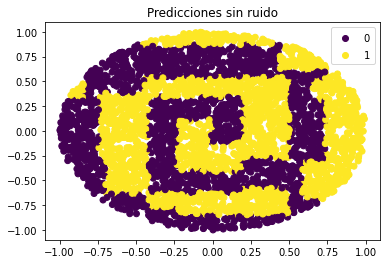

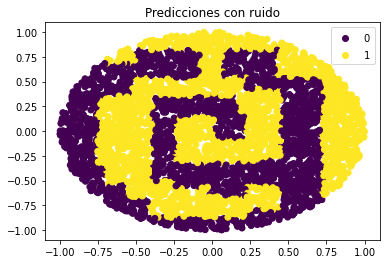

In [93]:
ej1_ad()

## Ejercicio 2

In [122]:
def ej2(min_k=True):
    ds = [2, 4, 6, 8, 16, 32]

    test_errors_a = []
    test_errors_b = []
    train_errors_a = []
    train_errors_b = []

    dd = []
    for d in ds:
        for i in range(0, 20):
            dd.append(d)
            cols = list(map(str, list(range(0, d))))
            # Generamos el conjunto de testeo
            test_a = generate_dataframe_a(d = d, n = 10000, C = 0.78)
            test_set_a = test_a.loc[ : , cols ]
            y_test_set_a = test_a.loc[:, 'Class']

            test_b = generate_dataframe_b(d = d, n = 10000, C = 0.78)
            test_set_b = test_b.loc[ : , cols ]
            y_test_set_b = test_b.loc[:, 'Class']

            # Generamos el conjunto de entrenamiento
            train_set_a = generate_dataframe_a(d = d, n = 250, C = 0.78)
            train_set_b = generate_dataframe_b(d = d, n = 250, C = 0.78)


            Xtrain_a, Xval_a, ytrain_a, yval_a = train_test_split(
                train_set_a.loc[ : , cols ],
                train_set_a.loc[:, 'Class'],
                test_size=0.2, 
                random_state=0
            )

            Xtrain_b, Xval_b, ytrain_b, yval_b = train_test_split(
                train_set_b.loc[ : , cols ],
                train_set_b.loc[:, 'Class'],
                test_size=0.2, 
                random_state=0
            )

            if min_k:
                et_a, ev_a, ett_a, clf_a = get_best_clf(Xtrain_a, ytrain_a, test_set_a, y_test_set_a, Xval_a, yval_a)
                clf_a.fit(Xtrain_a, ytrain_a)

                et_b, ev_b, ett_b, clf_b = get_best_clf(Xtrain_b, ytrain_b, test_set_b, y_test_set_b, Xval_b, yval_b)
                clf_b.fit(Xtrain_b, ytrain_b)
            else:
               clf_a = KNeighborsClassifier(n_neighbors=1)
               clf_b = KNeighborsClassifier(n_neighbors=1)
               clf_a.fit(Xtrain_a, ytrain_a)
               clf_b.fit(Xtrain_b, ytrain_b)

            # Predecimos sobre el conjunto de testeo
            prediction_a = clf_a.predict(test_set_a)
            prediction_b = clf_b.predict(test_set_b)
            prediction_train_a = clf_a.predict(train_set_a.loc[ : , cols])
            prediction_train_b = clf_b.predict(train_set_b.loc[ : , cols])

            # Guardamos el error (1 - accuracy) sobre el conjunto de testeo
            # y el de entrenamiento.
            test_errors_a.append(1 - accuracy_score(y_test_set_a, prediction_a))
            test_errors_b.append(1 - accuracy_score(y_test_set_b, prediction_b))
            train_errors_a.append(1 - accuracy_score(train_set_a.loc[:, 'Class'], prediction_train_a))
            train_errors_b.append(1 - accuracy_score(train_set_b.loc[:, 'Class'], prediction_train_b))

    # Creamos los dataframes con cada valor de C y su respectivo error (20 errores por cada N habrá)
    df_a = pd.DataFrame({})
    df_a['d'] = dd
    df_a['Test Error'] = test_errors_a
    df_a['Train Error'] = train_errors_a

    df_b = pd.DataFrame({})
    df_b['d'] = dd
    df_b['Test Error'] = test_errors_b
    df_b['Train Error'] = train_errors_b

    # Agrupamos y calculamos el promedio de error para cada valor de C
    mean_test_error_a = df_a.groupby('d')['Test Error'].mean().to_numpy()
    mean_test_error_b = df_b.groupby('d')['Test Error'].mean().to_numpy()
    mean_train_error_a = df_a.groupby('d')['Train Error'].mean().to_numpy()
    mean_train_error_b = df_b.groupby('d')['Train Error'].mean().to_numpy()
    # Guardamos los resultados obtenidos en los dataframes
    error_df_a = pd.DataFrame({})
    error_df_a['d'] = ds
    error_df_a['Test Error'] = mean_test_error_a
    error_df_a['Train Error'] = mean_train_error_a

    error_df_b = pd.DataFrame({})
    error_df_b['d'] = ds
    error_df_b['Test Error'] = mean_test_error_b
    error_df_b['Train Error'] = mean_train_error_b

    # Graficamos
    plt.plot(error_df_a['d'], error_df_a['Test Error'], 'r')
    plt.plot(error_df_b['d'], error_df_b['Test Error'], 'b')
    plt.plot(error_df_a['d'], error_df_a['Train Error'], 'g')
    plt.plot(error_df_b['d'], error_df_b['Train Error'], 'y')
    plt.legend(['Diag Test', 'Paral Test', 'Diag Train', 'Paral Train'], bbox_to_anchor=(0.75, 1.15), ncol=2)
    plt.xlabel('d')
    plt.ylabel('Error')

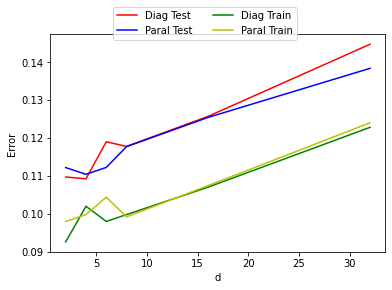

In [120]:
ej2()

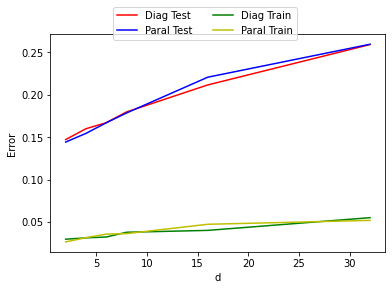

In [123]:
ej2(False) # pasandole el parametro False hacemos que use un solo vecino

## Ejercicio 3

## Ejercicio 4

In [100]:
n_vecinos = [2, 4, 8, 16, 32]
def get_best_clf_regressor(x_train, y_train, x_test, y_test, x_val, y_val, w):

    # w = 'uniform' o 'distance'

    errores_train = []
    errores_test = []
    errores_val = []
    best_e = None
    best_clf = None
    

    for n in n_vecinos:    
        clf = KNeighborsRegressor(n_neighbors=n, weights=w)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        y_pred_train = clf.predict(x_train)
        y_pred_val = clf.predict(x_val)

        e_train = mean_squared_error(y_train, y_pred_train)
        e_test = mean_squared_error(y_test, y_pred)
        e_val = mean_squared_error(y_val, y_pred_val)

        errores_test.append(e_test)
        errores_train.append(e_train)
        errores_val.append(e_val)

        if best_e is None or e_val < best_e:
            best_e = e_test
            best_clf = clf

    return errores_train, errores_val, errores_test, best_clf

In [116]:
def ej4(dataset_train, dataset_test, cols, w, title, delim=False):
    train = pd.read_csv(dataset_train, names=cols, delim_whitespace=delim)
    test = pd.read_csv(dataset_test, names=cols, delim_whitespace=delim)

    # if delim:
    #     print('lol')
    #     test = test.apply(pd.to_numeric, args=('coerce',))

    l = len(cols)

    x_train, x_val, y_train, y_val = train_test_split(
        train.loc[ : , cols[0 : (l - 1)] ], 
        train.loc[ : , [l - 1] ], 
        test_size=0.2, 
        random_state=0
    )

    x_test = test.loc[ : , cols[0 : (l - 1)] ]
    y_test = test.loc[ : , [l - 1] ]

    et, ev, ett, clf = get_best_clf_regressor(x_train, y_train, x_test, y_test, x_val, y_val, w)

    graficar_errores(n_vecinos, et, ev, ett, title)


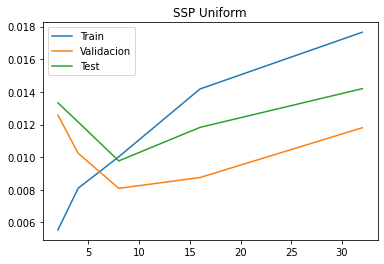

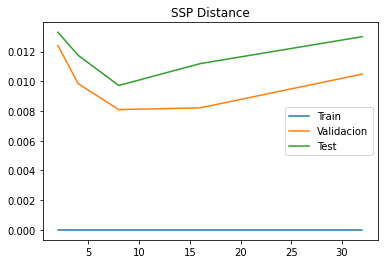

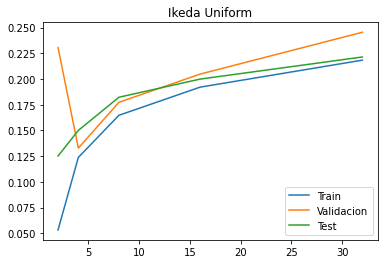

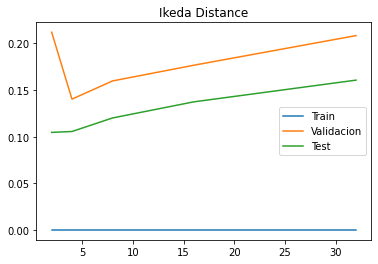

In [117]:
## SSP Uniform
ej4('datasets/ssp.data', 'datasets/ssp.test', list(range(13)), 'uniform', 'SSP Uniform')

## SSP Distance
ej4('datasets/ssp.data', 'datasets/ssp.test', list(range(13)), 'distance', 'SSP Distance')

## Ikeda Uniform
ej4('datasets/ikeda.data', 'datasets/ikeda.test', list(range(6)), 'uniform', 'Ikeda Uniform', True)

## Ikeda Distance
ej4('datasets/ikeda.data', 'datasets/ikeda.test', list(range(6)), 'distance', 'Ikeda Distance', True)

## Ejercicio 5

## Ejercicio 6